### Exploring the impacts of a high school student's academic performance
The dataset includes information collected through school reports and questionnaires, encompassing a wide range of features such as student grades, demographics, social factors, parental involvement, and school-related attributes.

The link to the data source can be found here from Kaggle: https://www.kaggle.com/datasets/dillonmyrick/high-school-student-performance-and-demographics?resource=downloadLinks to an external site.

citation: P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

### Data Setup

In [2]:
warnings.filterwarnings(action='ignore', category=UserWarning)
df = pd.read_csv('data/student_math_clean.csv')
df.head()

,student_id,school,sex,age,address_type,family_size,parent_status,mother_education,father_education,mother_job,...,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
0,1,GP,F,18,Urban,Greater than 3,Apart,higher education,higher education,at_home,...,4,3,4,1,1,3,6,5,6,6
1,2,GP,F,17,Urban,Greater than 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,5,3,3,1,1,3,4,5,5,6
2,3,GP,F,15,Urban,Less than or equal to 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,4,3,2,2,3,3,10,7,8,10
3,4,GP,F,15,Urban,Greater than 3,Living together,higher education,5th to 9th grade,health,...,3,2,2,1,1,5,2,15,14,15
4,5,GP,F,16,Urban,Greater than 3,Living together,secondary education,secondary education,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   student_id             395 non-null    int64 
 1   school                 395 non-null    object
 2   sex                    395 non-null    object
 3   age                    395 non-null    int64 
 4   address_type           395 non-null    object
 5   family_size            395 non-null    object
 6   parent_status          395 non-null    object
 7   mother_education       395 non-null    object
 8   father_education       395 non-null    object
 9   mother_job             395 non-null    object
 10  father_job             395 non-null    object
 11  school_choice_reason   395 non-null    object
 12  guardian               395 non-null    object
 13  travel_time            395 non-null    object
 14  study_time             395 non-null    object
 15  class_failures         

#### Determine pass/fail treshold and apply it to our merged dataset
To determine pass/fail treshold, we will explore final grade values using a histogram and exploring the mean, median and mode of the final grade

In [4]:
#Standardize the final grade out of 100 instead of 20
df['final_grade'] = df['final_grade']*5

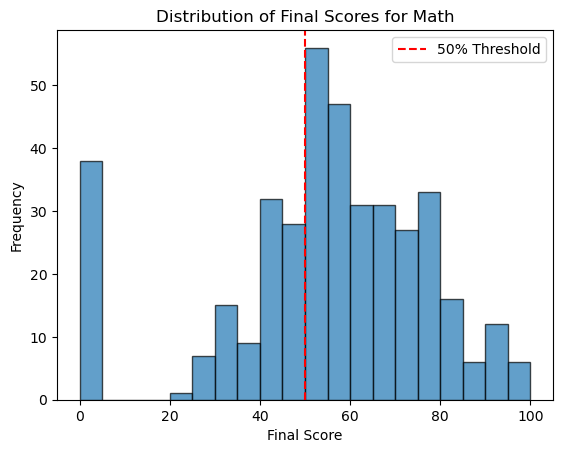

In [5]:
plt.hist(df['final_grade'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Final Score')
plt.ylabel('Frequency')
plt.title('Distribution of Final Scores for Math')
plt.axvline(x=50, color='r', linestyle='--', label='50% Threshold')
plt.legend()

In [6]:
# Check the mean, median, and mode
mean_score = (df['final_grade']).mean()
median_score = (df['final_grade']).median()
mode_score = (df['final_grade']).mode()[0]

print(f'Mean Math Score: {mean_score}')
print(f'Median Math Score: {median_score}')
print(f'Mode Math Score: {mode_score}')

Mean Math Score: 52.075949367088604
Median Math Score: 55.0
Mode Math Score: 50


#### Based on our analysis, 50% will be our pass fail threshold

In [7]:
threshold = 50
df['pass_fail'] = df['final_grade'].apply(lambda x: 'pass' if x >= threshold else 'fail')
df = df.drop('final_grade', axis=1)
df.head()

,student_id,school,sex,age,address_type,family_size,parent_status,mother_education,father_education,mother_job,...,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,pass_fail
0,1,GP,F,18,Urban,Greater than 3,Apart,higher education,higher education,at_home,...,4,3,4,1,1,3,6,5,6,fail
1,2,GP,F,17,Urban,Greater than 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,5,3,3,1,1,3,4,5,5,fail
2,3,GP,F,15,Urban,Less than or equal to 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,4,3,2,2,3,3,10,7,8,pass
3,4,GP,F,15,Urban,Greater than 3,Living together,higher education,5th to 9th grade,health,...,3,2,2,1,1,5,2,15,14,pass
4,5,GP,F,16,Urban,Greater than 3,Living together,secondary education,secondary education,other,...,4,3,2,1,2,5,4,6,10,pass


### Data exploration and clean up
Examine data for null values, duplicate values, and the relationships between different rows

In [8]:
df.isnull().sum()

student_id               0
school                   0
sex                      0
age                      0
address_type             0
family_size              0
parent_status            0
mother_education         0
father_education         0
mother_job               0
father_job               0
school_choice_reason     0
guardian                 0
travel_time              0
study_time               0
class_failures           0
school_support           0
family_support           0
extra_paid_classes       0
activities               0
nursery_school           0
higher_ed                0
internet_access          0
romantic_relationship    0
family_relationship      0
free_time                0
social                   0
weekday_alcohol          0
weekend_alcohol          0
health                   0
absences                 0
grade_1                  0
grade_2                  0
pass_fail                0
dtype: int64

#### Drop student ID column

In [9]:
df = df.drop('student_id', axis=1)

In [10]:
df.duplicated().sum()

0

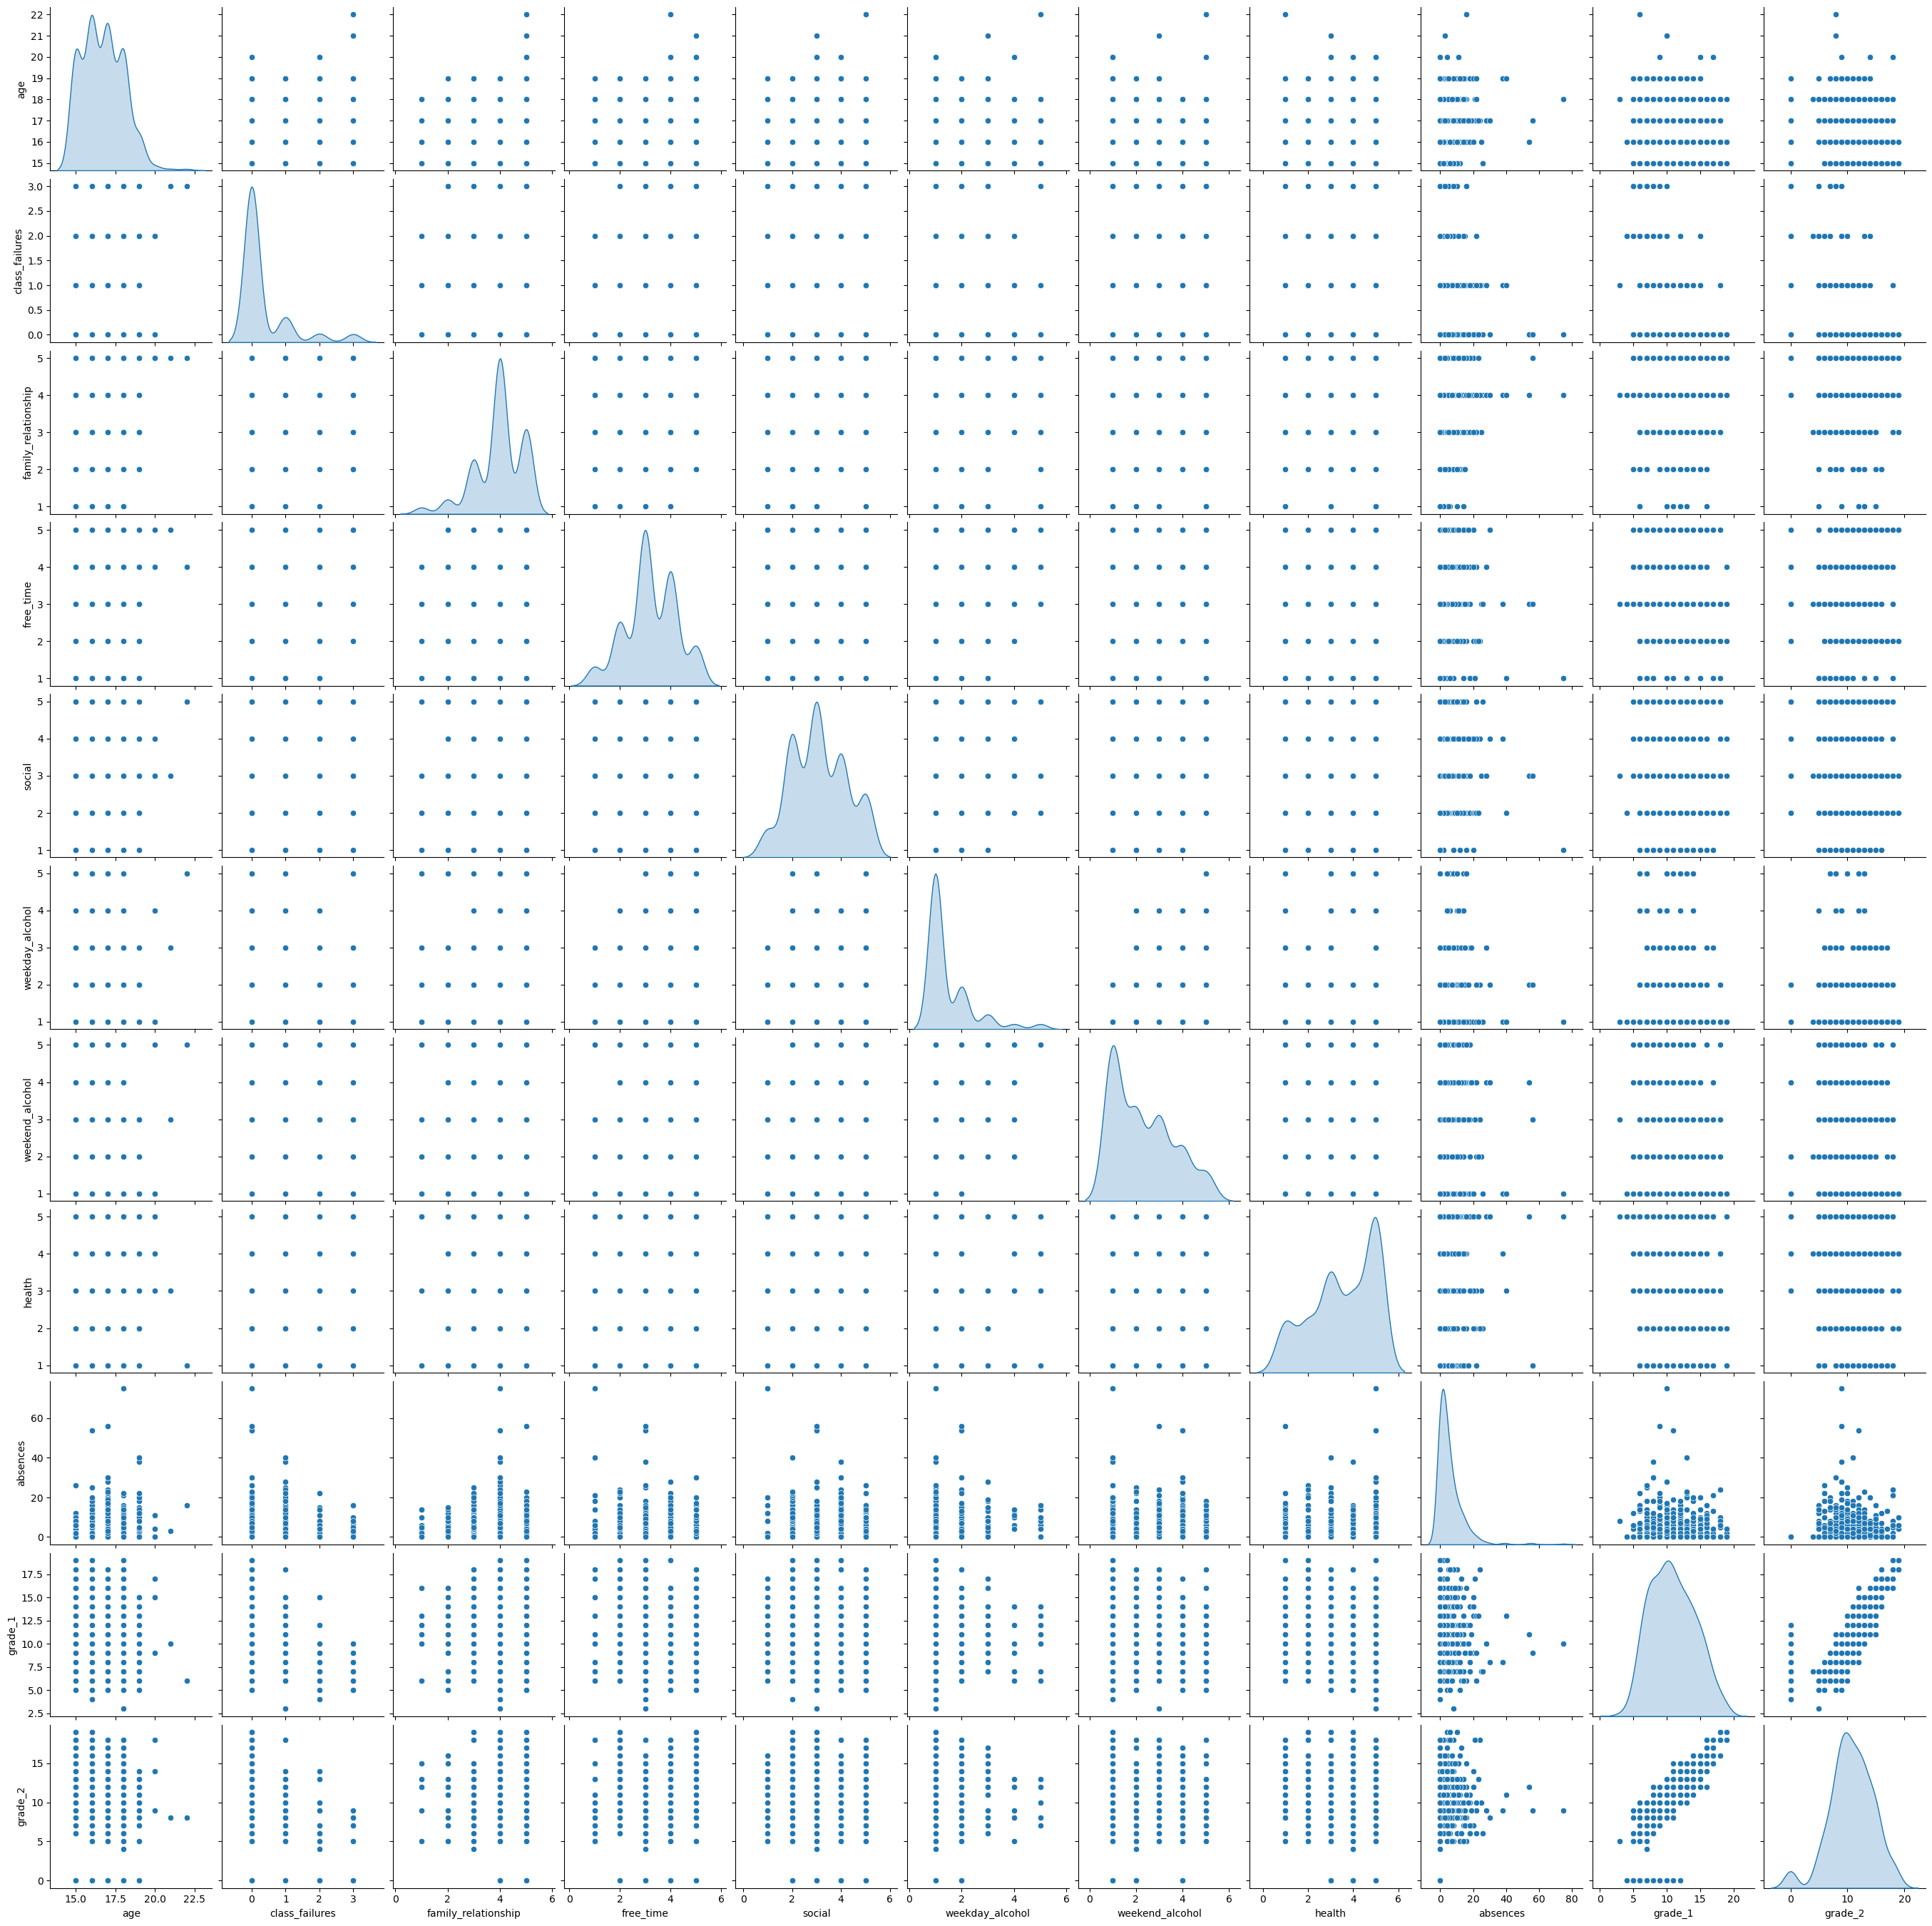

In [11]:
sns.pairplot(df, diag_kind='kde')
plt.show()

### Explore interesting relationships between colmns

Text(0.5, 1.0, 'Relationship between grade 1 and absences')

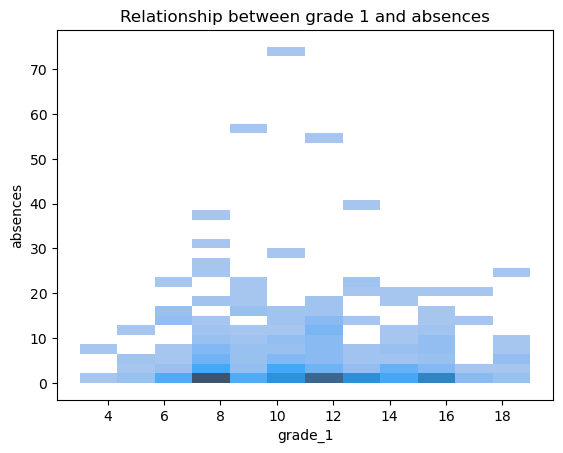

In [12]:
sns.histplot(x=df['grade_1'],y=df['absences'], kde=True)
plt.title("Relationship between grade 1 and absences")

Text(0.5, 1.0, 'Relationship between grade 2 and absences')

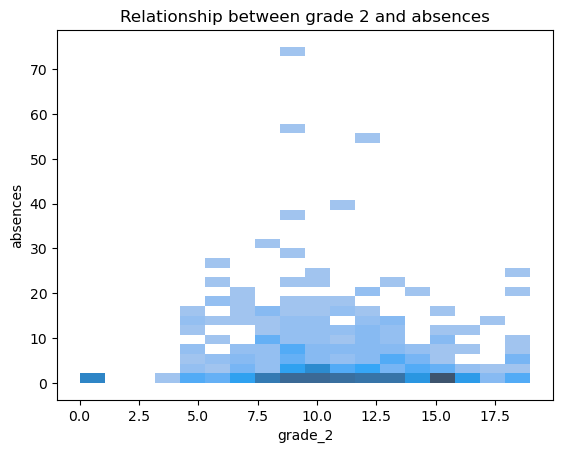

In [13]:
sns.histplot(x=df['grade_2'],y=df['absences'], kde=True)
plt.title("Relationship between grade 2 and absences")

Text(0.5, 1.0, 'Relationship between class failures and Grade 1')

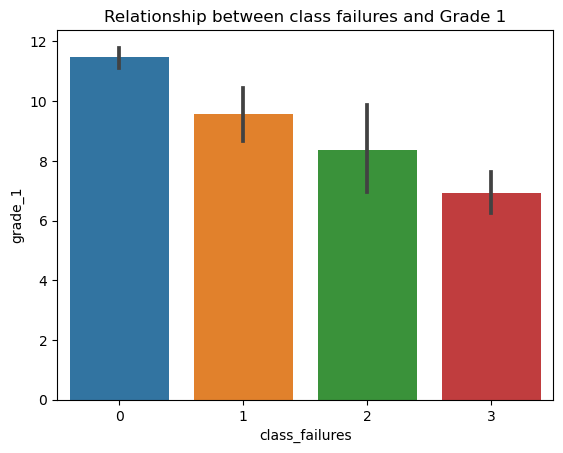

In [14]:
sns.barplot(x='class_failures', y='grade_1', data=df)
plt.title("Relationship between class failures and Grade 1")

Text(0.5, 1.0, 'Relationship between class failures and Grade 2')

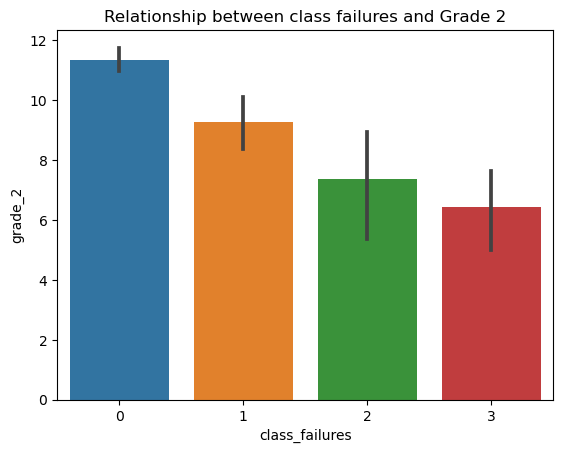

In [15]:
sns.barplot(x='class_failures', y='grade_2', data=df)
plt.title("Relationship between class failures and Grade 2")

Text(0.5, 1.0, 'Relationship between study time and Grade 1')

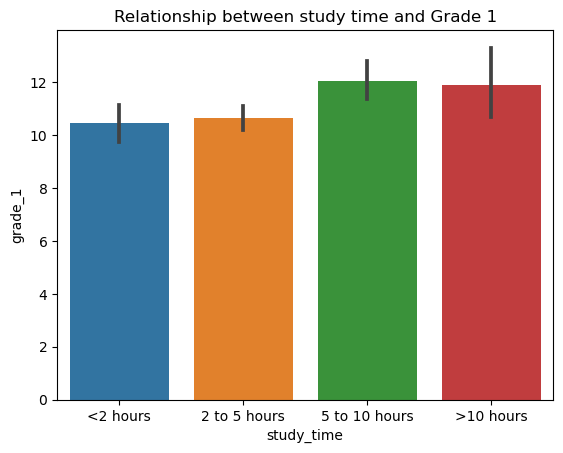

In [16]:
ordering = ['<2 hours', '2 to 5 hours', '5 to 10 hours', '>10 hours']
sns.barplot(x='study_time', y='grade_1', data=df, order = ordering)
plt.title("Relationship between study time and Grade 1")

Text(0.5, 1.0, 'Relationship between study time and Grade 2')

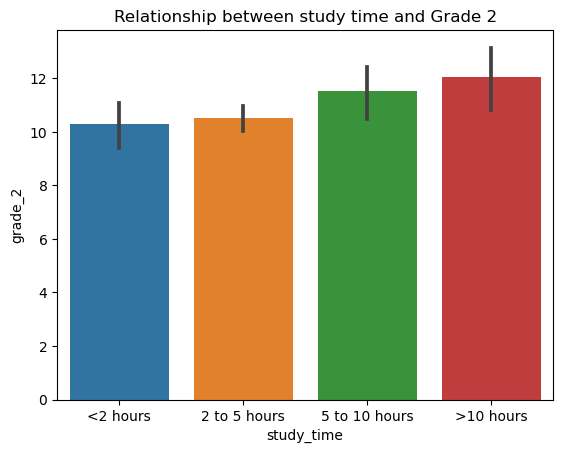

In [17]:
ordering = ['<2 hours', '2 to 5 hours', '5 to 10 hours', '>10 hours']
sns.barplot(x='study_time', y='grade_2', data=df, order = ordering)
plt.title("Relationship between study time and Grade 2")

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Features')

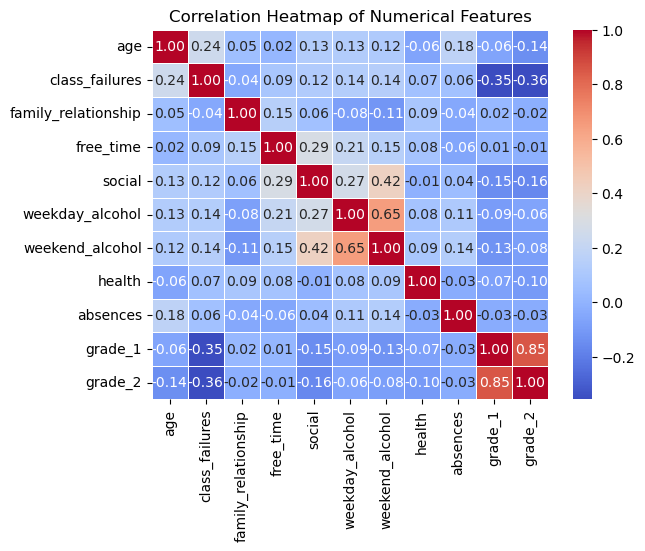

In [18]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features')

### Split Data and encode values for our models

In [19]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
categorical_cols = df.select_dtypes(include=['object']).columns.to_list()
categorical_cols.remove('pass_fail')

In [20]:
label_encoder = LabelEncoder()
for column in numerical_cols:
    df[column] = label_encoder.fit_transform(df[column])
df_encoded = pd.get_dummies(df, columns= categorical_cols, drop_first=True)
df_encoded['pass_fail'] = df_encoded['pass_fail'].map({'pass': True, 'fail': False})

In [21]:
X = df_encoded.drop('pass_fail', axis=1)
y = df_encoded['pass_fail']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### A Baseline Model using DummyClassifier

In [22]:
dummy_clf = DummyClassifier().fit(X_train, y_train)
baseline_score = dummy_clf.score(X_test, y_test)
print('Baseline score:', baseline_score)

Baseline score: 0.6363636363636364


### Build and compare 4 models with hyperparameter tuning using GridSearchCV

In [23]:
param_grid_logistic_regression = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1],
}
param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [10, 20, 30, 40, 50, None]
}
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}
param_grid_svc = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'gamma': ['scale', 'auto'], 
    'degree': [3, 4, 5],
    'coef0': [0.0, 0.1, 0.5, 1.0] 
}

In [24]:
logistic_regression_model = LogisticRegression(max_iter=1000)
grid_search_logistic_regression = GridSearchCV(estimator=logistic_regression_model, param_grid=param_grid_logistic_regression, cv=5)

decision_tree_model = DecisionTreeClassifier()
grid_search_decision_tree = GridSearchCV(estimator=decision_tree_model, param_grid=param_grid_decision_tree, cv=5)

# K-Nearest Neighbors
knn_model = KNeighborsClassifier()
grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid_knn, cv=5, n_jobs=-1)

# Support Vector Machine
svm_model = SVC()
grid_search_svc = GridSearchCV(estimator=svm_model, param_grid=param_grid_svc, cv=5)

In [25]:
grid_search_logistic_regression.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2']})

In [26]:
grid_search_decision_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50, None],
                         'splitter': ['best', 'random']})

In [27]:
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [28]:
grid_search_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'coef0': [0.0, 0.1, 0.5, 1.0], 'degree': [3, 4, 5],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

### Score each model and asses their performance

Logistic regression fit time:    0.0172
              precision    recall  f1-score   support

       False       0.89      0.92      0.90        36
        True       0.95      0.94      0.94        63

    accuracy                           0.93        99
   macro avg       0.92      0.93      0.92        99
weighted avg       0.93      0.93      0.93        99



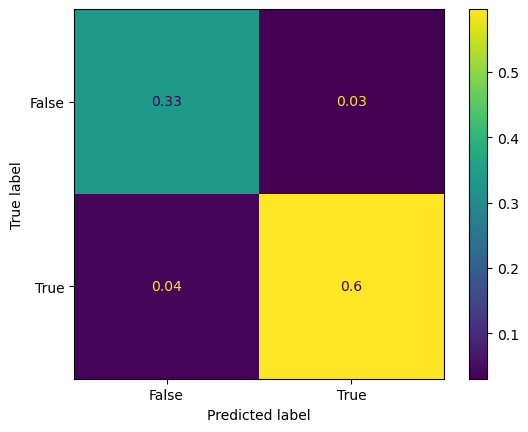

In [29]:
LTRS = grid_search_logistic_regression.score(X_train, y_train)
LTES = grid_search_logistic_regression.score(X_test, y_test)
mean_fit_time = grid_search_logistic_regression.cv_results_['mean_fit_time']
Ltime = np.mean(mean_fit_time)
print("Logistic regression fit time:   ",np.round(Ltime, 4))
y_pred = grid_search_logistic_regression.predict(X_test)
print(classification_report(y_test, y_pred))
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='all')
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_search_logistic_regression.classes_)
disp.plot()

Decision tree fit time:    0.0053
              precision    recall  f1-score   support

       False       0.91      0.83      0.87        36
        True       0.91      0.95      0.93        63

    accuracy                           0.91        99
   macro avg       0.91      0.89      0.90        99
weighted avg       0.91      0.91      0.91        99



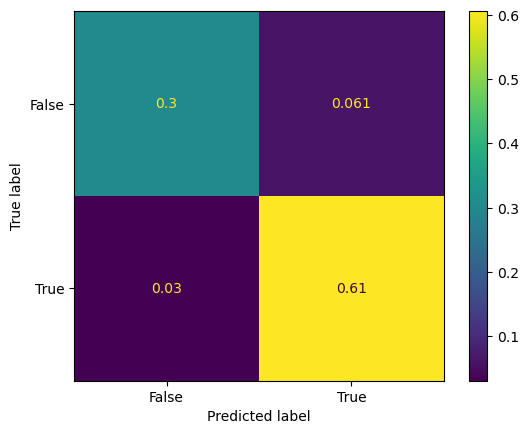

In [30]:
DTRS = grid_search_decision_tree.score(X_train, y_train)
DTES = grid_search_decision_tree.score(X_test, y_test)
mean_fit_time = grid_search_decision_tree.cv_results_['mean_fit_time']
Dtime = np.mean(mean_fit_time)
print("Decision tree fit time:   ",np.round(Dtime, 4))
y_pred = grid_search_decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='all')
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_search_decision_tree.classes_)
disp.plot()

KNN fit time:    0.0105
              precision    recall  f1-score   support

       False       0.85      0.81      0.83        36
        True       0.89      0.92      0.91        63

    accuracy                           0.88        99
   macro avg       0.87      0.86      0.87        99
weighted avg       0.88      0.88      0.88        99



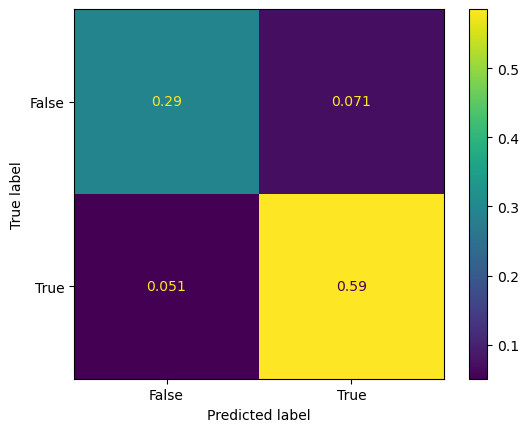

In [31]:
KTRS = grid_search_knn.score(X_train, y_train)
KTES = grid_search_knn.score(X_test, y_test)
mean_fit_time = grid_search_knn.cv_results_['mean_fit_time']
Ktime = np.mean(mean_fit_time)
print("KNN fit time:   ",np.round(Ktime, 4))
y_pred = grid_search_knn.predict(X_test)
print(classification_report(y_test, y_pred))
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='all')
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_search_knn.classes_)
disp.plot()

SVC fit time:    0.0064
              precision    recall  f1-score   support

       False       0.84      0.86      0.85        36
        True       0.92      0.90      0.91        63

    accuracy                           0.89        99
   macro avg       0.88      0.88      0.88        99
weighted avg       0.89      0.89      0.89        99



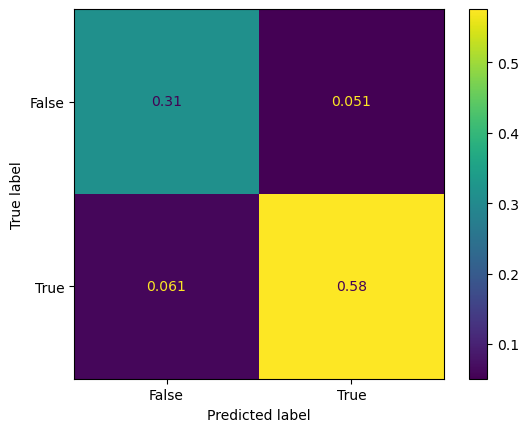

In [32]:
STRS = grid_search_svc.score(X_train, y_train)
STES = grid_search_svc.score(X_test, y_test)
mean_fit_time = grid_search_svc.cv_results_['mean_fit_time']
Stime = np.mean(mean_fit_time)
print("SVC fit time:   ",np.round(Stime, 4))
y_pred = grid_search_svc.predict(X_test)
print(classification_report(y_test, y_pred))
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='all')
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_search_svc.classes_)
disp.plot()

In [33]:
#Using the scores, build a dataframe sorted by test score
data = {
    'model': ['Logistic Regression', 'Decision Tree', 'KNN', 'SVC'],
    'train score': [LTRS, DTRS, KTRS, STRS],
    'test score': [LTES, DTES, KTES, STES],
    'average fit time': [Ltime, Dtime, Ktime, Stime]
}
results_df = pd.DataFrame(data)
# Sort by 'test score' column
sorted_df = results_df.sort_values(by='test score', ascending=False)
sorted_df

,model,train score,test score,average fit time
0,Logistic Regression,0.972973,0.929293,0.017182
1,Decision Tree,0.996622,0.909091,0.005284
3,SVC,1.000000,0.888889,0.006384
2,KNN,1.000000,0.878788,0.010501


### Model findings

After evaluating four classification models—Logistic Regression, Support Vector Classifier (SVC), K-Nearest Neighbors (KNN), and Decision Tree—on the given dataset, the following results were obtained:

__Logistic regression:__  Was the best model with a train score of 0.973 and a test score of 0.929. Despite the longer fit time of 0.019 seconds, the good performance of the test represents a good balance between fitting the training data.

__Support Vector Classifier (SVC):__ Achieved a perfect train score of 1.000 but had a lower test score of 0.889, indicating potential overfitting. Its average fit time was the second lowest at 0.006 seconds.

__K-Nearest Neighbors (KNN):__ Obtained a perfect train score of 1.000 but performed slightly worse on the test data with a score of 0.879. Its average fit time was 0.010 seconds.

__Decision Tree (DT):__ Similarly achieved a perfect train score of 1.000 but had the lowest test score of 0.859, suggesting overfitting. It had the lowest average fit time of all models at 0.005 seconds.

### Feature Importance of our best model Logistic Regression

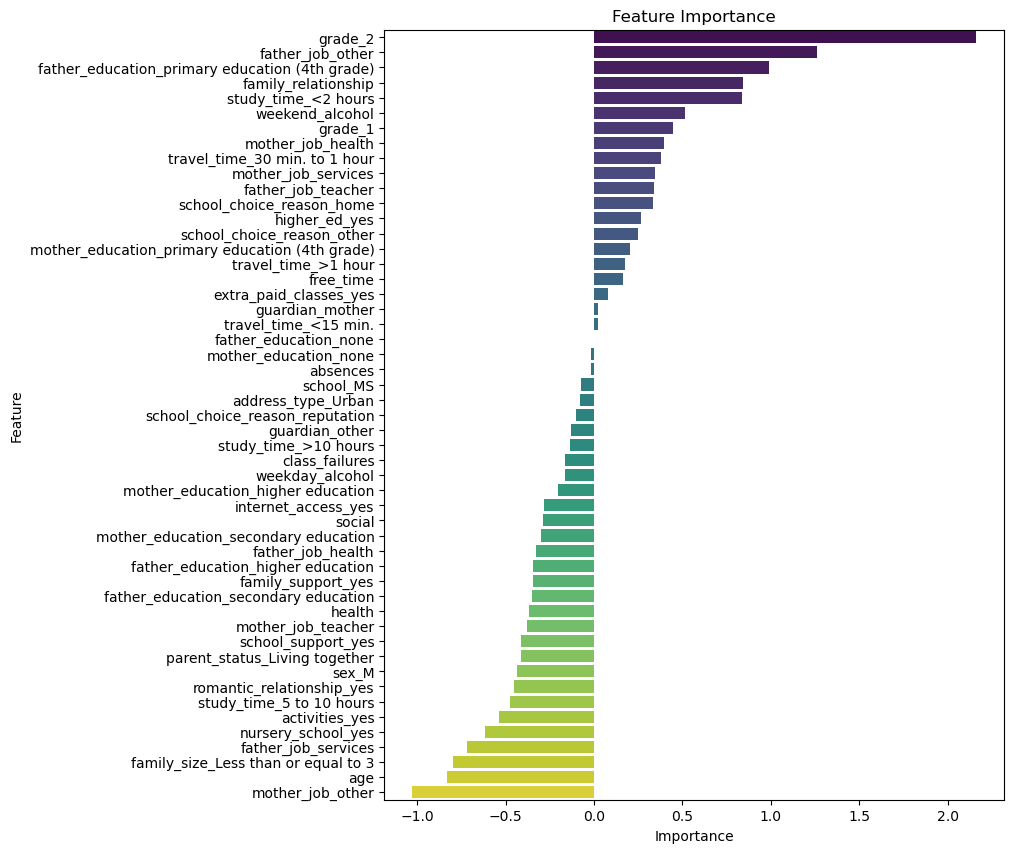

In [34]:
best_logistic_regression_model = grid_search_logistic_regression.best_estimator_
feature_importance = best_logistic_regression_model.coef_[0]
features = X_train.columns
indices = np.argsort(feature_importance)[::-1]
importance_df = pd.DataFrame({
    'Feature': [features[i] for i in indices],
    'Importance': feature_importance[indices]
})

plt.figure(figsize=(8, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importance")
plt.show()

#### Top 4 features 

In [35]:
 importance_df.loc[1:4]

,Feature,Importance
1,father_job_other,1.258793
2,father_education_primary education (4th grade),0.988324
3,family_relationship,0.842129
4,study_time_<2 hours,0.834632


### Conclusion

The analysis of feature importance reveals several key factors that contribute to a student's likelihood of failing a class. Based on these findings, schools can implement targeted interventions to address these issues and improve student outcomes. Some of the recommended actions based on the identified important features are:
* Provide Career Counseling and Support: Offer career counseling and support services for families
* Create programs to encourage and facilitate further education for parents. This could involve adult education classes, literacy programs, and informational sessions about the importance of education.
* Develop programs that foster positive family relationships. This could include family counseling, workshops on effective communication, and family bonding activities.
* Implement study skills workshops, provide resources for effective time management, and establish homework clubs or study groups to ensure students are dedicating adequate time to their studies.